# Predict sales - sports companies

## Importations

In [2]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB

import pickle
import warnings

## Load data 

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [5]:
dataset_train, dataset_test = load_train_test()
dataset_train.isna().sum()

/tmp/ipykernel_1481/2459610029.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")


customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              222825
mcp_contact_id             70874
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                224213
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date           66139
max_price                  66139
ticket_sum                     0
average_price              66023
average_purchase_delay     66139
average_price_basket       66139
average_ticket_basket      66139
total_price                  116
purchase_count                 0
first_buying_date          66139
country   

In [7]:
def features_target_split(dataset_train, dataset_test):
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']
            """

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 14)
Shape test :  (96096, 14)


## Logistic

In [96]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5837086520288036, 1.0: 3.486549107420539}

In [97]:
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [98]:
# preprocess data 
# numeric features - standardize
# categorical features - encode
# encoded features - do nothing

numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                    'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet', 'nb_campaigns', 
                    'nb_campaigns_opened' # , 'gender_male', 'gender_female'
                   ]

numeric_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="mean")),  
    ("scaler", StandardScaler()) 
])

categorical_features = ['opt_in', 'is_email_true']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [99]:
X_train[numeric_features].isna().sum()

nb_tickets             0
nb_purchases           0
total_amount           0
nb_suppliers           0
vente_internet_max     0
purchase_date_min      0
purchase_date_max      0
nb_tickets_internet    0
nb_campaigns           0
nb_campaigns_opened    0
dtype: int64

In [100]:
# Set loss
balanced_scorer = make_scorer(balanced_accuracy_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

In [101]:
def draw_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def draw_roc_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    
    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (14, 8))
    plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC : modèle logistique')
    plt.legend(loc="lower right")
    plt.show()

In [102]:
def draw_features_importance(pipeline, model):
    coefficients = pipeline.named_steps['logreg'].coef_[0]
    feature_names = pipeline.named_steps['logreg'].feature_names_in_
    
    # Tracer l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel('Importance des caractéristiques')
    plt.ylabel('Caractéristiques')
    plt.title('Importance des caractéristiques dans le modèle de régression logistique')
    plt.grid(True)
    plt.show()

def draw_prob_distribution(X_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred_prob, bins=10, range=(0, 1), color='blue', alpha=0.7)
    
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    plt.title('Histogramme des probabilités pour la classe 1')
    plt.xlabel('Probabilité')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [103]:
# Hyperparameter

param_c = np.logspace(-10, 4, 15, base=2)
# param_penalty_type = ['l1', 'l2', 'elasticnet']
param_penalty_type = ['l1']
param_grid = {'logreg__C': param_c,
              'logreg__penalty': param_penalty_type} 

In [26]:
2 ** 10

1024

In [104]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('logreg', LogisticRegression(solver='saga', class_weight = weight_dict,
                                  max_iter=5000))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [105]:
# reduce X_train to reduce the training time

X_train_subsample = X_train.sample(n=1000, random_state=42)
y_train_subsample = y_train.loc[X_train_subsample.index]
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
43000          0.0           0.0           0.0           0.0   
183923         0.0           0.0           0.0           0.0   
97373          0.0           0.0           0.0           0.0   
66956          7.0           2.0         254.0           1.0   
116487         0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
140473         0.0           0.0           0.0           0.0   
153768         0.0           0.0           0.0           0.0   
110886        12.0           6.0         430.0           1.0   
115390         2.0           1.0          79.9           1.0   
24919          3.0           3.0         149.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
43000                  0.0         550.000000         550.000000   
183923                 0.0         550.000000         550.000000   
97373                  0.0         550.000000         550.000000   
66956                  1.0         378.343062         370.453947   
116487                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
140473                 0.0         550.000000         550.000000   
153768                 0.0         550.000000         550.000000   
110886                 1.0         490.688726         153.686330   
115390                 0.0          57.498524          57.498524   
24919                  0.0         457.437319         457.437169   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
43000                   0.0           True    True              0   
183923                  0.0           True    True              0   
97373                   0.0           True   False              0   
66956                   7.0           True   False              0   
116487                  0.0           True   False              1   
...                     ...            ...     ...            ...   
140473                  0.0           True    True              1   
153768                  0.0           True    True              1   
110886                 12.0           True   False              1   
115390                  0.0           True   False              0   
24919                   0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
43000             1          14.0                 12.0  
183923            1          19.0                 11.0  
97373             0           7.0                  2.0  
66956             1           0.0                  0.0  
116487            0           5.0                  0.0  
...             ...           ...                  ...  
140473            0          83.0                 11.0  
153768            0          12.0                  1.0  
110886            0          40.0                 12.0  
115390            1          11.0                  6.0  
24919             1           0.0                  0.0  

[1000 rows x 14 columns]

In [108]:
y_train_subsample

y_has_purchased
43000               0.0
183923              0.0
97373               0.0
66956               1.0
116487              0.0
...                 ...
140473              0.0
153768              0.0
110886              1.0
115390              0.0
24919               0.0

[1000 rows x 1 columns]

In [109]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [110]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1']}

In [46]:
f1_scorer

make_scorer(f1_score, response_method='predict')

In [111]:
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
43000          0.0           0.0           0.0           0.0   
183923         0.0           0.0           0.0           0.0   
97373          0.0           0.0           0.0           0.0   
66956          7.0           2.0         254.0           1.0   
116487         0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
140473         0.0           0.0           0.0           0.0   
153768         0.0           0.0           0.0           0.0   
110886        12.0           6.0         430.0           1.0   
115390         2.0           1.0          79.9           1.0   
24919          3.0           3.0         149.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
43000                  0.0         550.000000         550.000000   
183923                 0.0         550.000000         550.000000   
97373                  0.0         550.000000         550.000000   
66956                  1.0         378.343062         370.453947   
116487                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
140473                 0.0         550.000000         550.000000   
153768                 0.0         550.000000         550.000000   
110886                 1.0         490.688726         153.686330   
115390                 0.0          57.498524          57.498524   
24919                  0.0         457.437319         457.437169   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
43000                   0.0           True    True              0   
183923                  0.0           True    True              0   
97373                   0.0           True   False              0   
66956                   7.0           True   False              0   
116487                  0.0           True   False              1   
...                     ...            ...     ...            ...   
140473                  0.0           True    True              1   
153768                  0.0           True    True              1   
110886                 12.0           True   False              1   
115390                  0.0           True   False              0   
24919                   0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
43000             1          14.0                 12.0  
183923            1          19.0                 11.0  
97373             0           7.0                  2.0  
66956             1           0.0                  0.0  
116487            0           5.0                  0.0  
...             ...           ...                  ...  
140473            0          83.0                 11.0  
153768            0          12.0                  1.0  
110886            0          40.0                 12.0  
115390            1          11.0                  6.0  
24919             1           0.0                  0.0  

[1000 rows x 14 columns]

In [112]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [113]:
# run the pipeline on the subsample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train_subsample, y_train_subsample)

# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(logit_grid.best_score_))
# print('Classification accuracy on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 4.0, 'logreg__penalty': 'l1'}
Best classification accuracy in train is: 0.4972844559251812


In [114]:
param_c

array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01])

In [96]:
logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [97]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1']}

In [98]:
# run the pipeline on the full sample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train, y_train)

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification accuracy in train is: 0.42160313383818665
Classification accuracy on test is: 0.47078982841737305


In [99]:
# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(logit_grid.best_score_))
print('Classification F1 score on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification F1 score in train is: 0.42160313383818665
Classification F1 score on test is: 0.47078982841737305


In [100]:
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [105]:
logit_grid.__dict__

{'scoring': make_scorer(f1_score, response_method='predict'),
 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['nb_tickets', 'nb_purchases',
                                                    'total_amount',
                                                    'nb_suppliers',
                                                    'vente_internet_max',
                                                    'purchase_date_min',
                                                    'purchase_date_max',
                                                    'nb_tickets_internet',
                                                    'nb_campaigns',
                                                    'nb_campaigns_opened']),
        

In [115]:
# coefficients trouvés pour le modèle optimal
logit_grid.best_estimator_.named_steps["logreg"].coef_

array([[ 0.64495866, -0.23909623,  0.54323933,  0.85687092, -0.04235755,
         0.87304348, -1.34756336,  0.21177838,  0.051939  ,  0.04496588,
         0.2103007 , -0.59054784,  0.        ,  0.        ]])

In [116]:
logit_grid.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['nb_tickets', 'nb_purchases', 'total_amount',
                                   'nb_suppliers', 'vente_internet_max',
                                   'purchase_date_min', 'purchase_date_max',
                                   'nb_tickets_internet', 'nb_campaigns',
                                   'nb_campaigns_opened']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['opt_in', 'is_email_true'])]),
 'logreg': LogisticRegression(C=4.0,
                    class_weight={0.0: 0.5837086520288036,
                                  1.0: 3.48654910742

In [117]:
logit_grid.best_estimator_.named_steps["logreg"].intercept_

array([-0.38031755])

In [115]:
# c'est la 2ème variable nb_purchases qui a été supprimée par le LASSO
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [118]:
# best param : alpha = 32 (alpha =1/4 sur le petit subsample)
1/logit_grid.best_params_["logreg__C"]

0.25

In [119]:
# print results for the best model

y_pred = logit_grid.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.7187395937395937
F1 Score: 0.44926236857119567
Recall Score: 0.8052593133674215


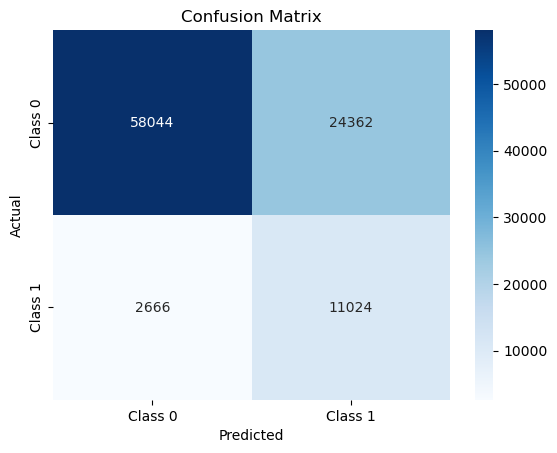

In [120]:
# confusion matrix 

draw_confusion_matrix(y_test, y_pred)

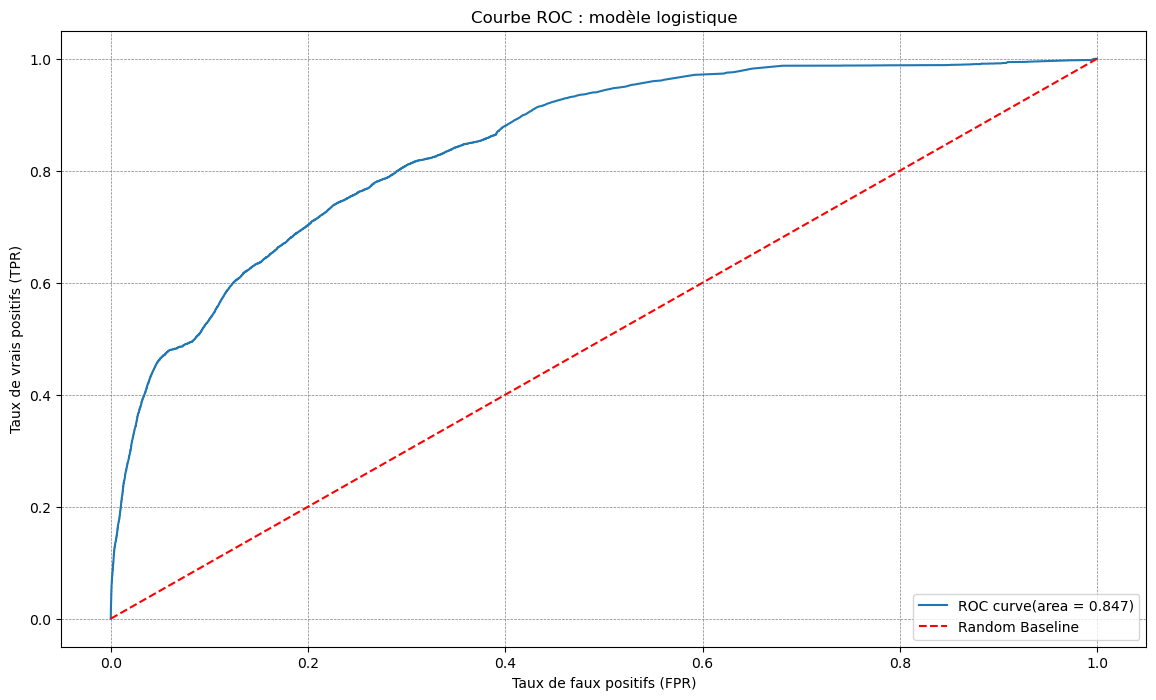

In [121]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = logit_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : modèle logistique')
plt.legend(loc="lower right")
plt.show()

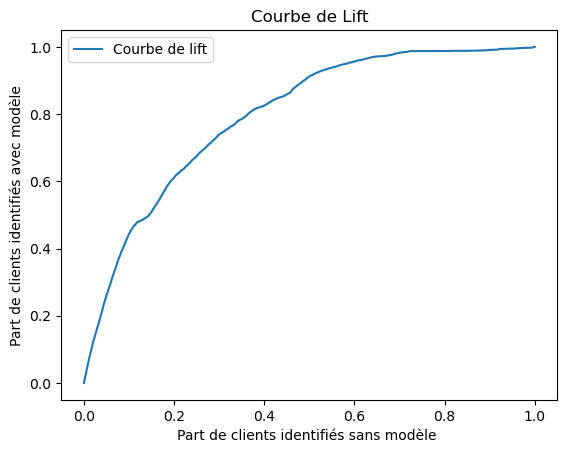

In [123]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label='Courbe de lift')
plt.xlabel('Part de clients identifiés sans modèle ')
plt.ylabel('Part de clients identifiés avec modèle')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

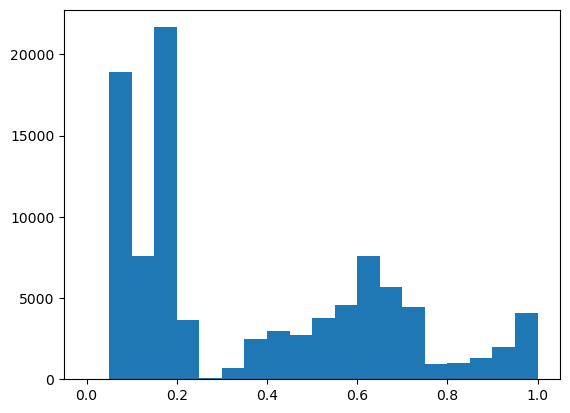

In [126]:
# look at the distribution of the score 

plt.hist(y_pred_prob, bins=20)
plt.show()

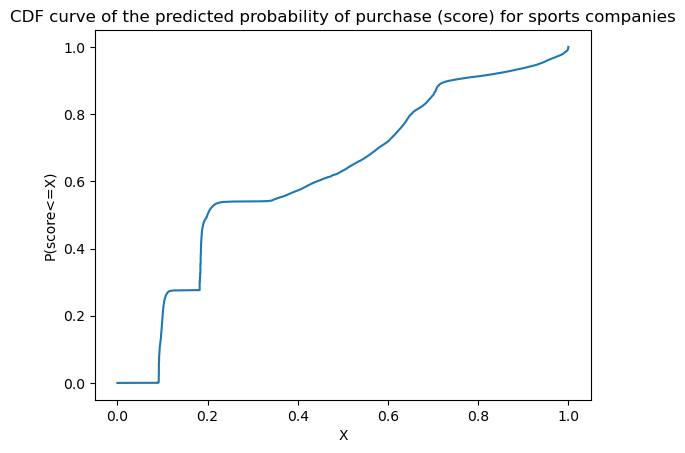

In [128]:
# number of observations
N = len(y_pred_prob)

# sort the data in ascending order 
y_pred_prob_sorted = np.sort(y_pred_prob) 

# get the cdf values of y 
steps = np.arange(N) / N
  
# plotting 
plt.xlabel('X') 
plt.ylabel('P(score<=X)') 
  
plt.title('CDF curve of the predicted probability of purchase (score) for sports companies') 
  
plt.plot(y_pred_prob_sorted, steps) 
plt.show()

In [178]:
# K-means clustering 

kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(y_pred_prob.reshape(-1,1))

KMeans(n_clusters=3, random_state=0)

In [179]:
y_clusters = kmeans.predict(y_pred_prob.reshape(-1,1))
y_clusters

array([2, 0, 2, ..., 0, 2, 0], dtype=int32)

In [180]:
# seuils des clusters et part de clients dans chacun d'eux

print(f"seuil cluster 0 : {y_pred_prob[y_clusters==0].max()} ({round(100 * (y_clusters==0).mean(), 2)}%)")
print(f"seuil cluster 2 : {y_pred_prob[y_clusters==2].max()} ({round(100 * (y_clusters==2).mean(), 2)}%)")
print(f"seuil cluster 1 : {y_pred_prob[y_clusters==1].max()} ({round(100* (y_clusters==1).mean(), 2)}%)")

seuil cluster 0 : 0.3666817620198657 (55.46%)
seuil cluster 2 : 0.7518681604748351 (34.86%)
seuil cluster 1 : 1.0 (9.68%)


In [181]:
# les individus des clusters sont-ils semblables ? def des marketing personae

X_test_clustered = X_test.assign(cluster = y_clusters)
X_test_clustered.head()

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   

   purchase_date_min  purchase_date_max  nb_tickets_internet  is_email_true  \
0           5.177187           5.177187                  0.0           True   
1         426.265613         426.265613                  0.0           True   
2         436.033437         436.033437                  0.0           True   
3           5.196412           5.196412                  0.0           True   
4         478.693148         115.631470                  0.0           True   

   opt_in  gender_female  gender_male  nb_campaigns  nb_campaigns_opened  \
0   False              1            0           0.0                  0.0   
1    True              0            1           0.0                  0.0   
2    True              1            0           0.0                  0.0   
3   False              1            0           0.0                  0.0   
4   False              1            0           0.0                  0.0   

   cluster  
0        2  
1        0  
2        2  
3        2  
4        1

In [182]:
X_test_clustered.groupby("cluster").median().iloc[[0,2,1], :]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
cluster                                                         
0               0.0           0.0         0.000           0.0   
2               2.0           1.0        59.000           1.0   
1              12.0           4.0       205.075           1.0   

         vente_internet_max  purchase_date_min  purchase_date_max  \
cluster                                                             
0                       0.0         550.000000         550.000000   
2                       1.0         232.198352         225.296614   
1                       1.0         416.542519          60.404957   

         nb_tickets_internet  is_email_true  opt_in  gender_female  \
cluster                                                              
0                        0.0            1.0     1.0            0.0   
2                        1.0            1.0     0.0            0.0   
1                        4.0            1.0     0.0            0.0   

         gender_male  nb_campaigns  nb_campaigns_opened  
cluster                                                  
0                0.0           7.0                  0.0  
2                1.0           3.0                  0.0  
1                1.0          16.0                  1.0

In [183]:
X_test_clustered.groupby("cluster").mean().iloc[[0,2,1], :]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
cluster                                                         
0          0.132484      0.067283      0.950238      0.025292   
2          2.956270      1.396973     77.660347      0.999164   
1         42.274898     10.682943   1859.028185      1.481824   

         vente_internet_max  purchase_date_min  purchase_date_max  \
cluster                                                             
0                  0.007149         545.999770         545.961714   
2                  0.659682         235.984535         229.598802   
1                  0.750376         386.850491          96.427147   

         nb_tickets_internet  is_email_true    opt_in  gender_female  \
cluster                                                                
0                   0.015142       1.000000  0.522619       0.240389   
2                   1.620787       0.991373  0.255246       0.258321   
1                  12.382663       0.973220  0.163261       0.197892   

         gender_male  nb_campaigns  nb_campaigns_opened  
cluster                                                  
0           0.431319     12.712442             2.241721  
2           0.558162     10.610967             2.741799  
1           0.609378     19.805442             7.528286

## Random forest

In [26]:
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
43000          0.0           0.0           0.0           0.0   
183923         0.0           0.0           0.0           0.0   
97373          0.0           0.0           0.0           0.0   
66956          7.0           2.0         254.0           1.0   
116487         0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
83146          1.0           1.0          35.0           1.0   
223586         0.0           0.0           0.0           0.0   
56489          0.0           0.0           0.0           0.0   
141236         0.0           0.0           0.0           0.0   
6999           2.0           1.0          20.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
43000                  0.0         550.000000         550.000000   
183923                 0.0         550.000000         550.000000   
97373                  0.0         550.000000         550.000000   
66956                  1.0         378.343062         370.453947   
116487                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
83146                  1.0          37.474040          37.474040   
223586                 0.0         550.000000         550.000000   
56489                  0.0         550.000000         550.000000   
141236                 0.0         550.000000         550.000000   
6999                   0.0         171.446921         171.446921   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
43000                   0.0           True    True              0   
183923                  0.0           True    True              0   
97373                   0.0           True   False              0   
66956                   7.0           True   False              0   
116487                  0.0           True   False              1   
...                     ...            ...     ...            ...   
83146                   1.0           True   False              0   
223586                  0.0           True    True              0   
56489                   0.0           True    True              0   
141236                  0.0           True   False              0   
6999                    0.0           True    True              1   

        gender_male  nb_campaigns  nb_campaigns_opened  
43000             1          14.0                 12.0  
183923            1          19.0                 11.0  
97373             0           7.0                  2.0  
66956             1           0.0                  0.0  
116487            0           5.0                  0.0  
...             ...           ...                  ...  
83146             1           9.0                  3.0  
223586            1          23.0                  1.0  
56489             1           4.0                  0.0  
141236            1           6.0                  0.0  
6999              0           0.0                  0.0  

[10000 rows x 14 columns]

### Preprocessing

In [10]:
# no need to standardize variables in a random forest
# we just encode categorical variables

categorical_features = ['opt_in', 'is_email_true']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [16]:
preproc

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['opt_in', 'is_email_true'])])

### Pipeline

In [ ]:
# Define models and parameters for GridSearch
model = {
        'model': RandomForestClassifier(),
        'params': {
            'randforest__n_estimators': [100, 150, 200, 250, 300],
            'randforest__max_depth': [None, 15, 20, 25, 30, 35, 40],
        }
    }

# Test each model using GridSearchCV
pipe = Pipeline(steps=[('preprocessor', preproc), ('randforest', model['model'])])
clf = GridSearchCV(pipe, model['params'], cv=3)
clf.fit(X_train, y_train)

print(f"Model: {model['model']}")
print(f"Best parameters: {clf.best_params_}")
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))
print("------")

In [43]:
# Pipeline - on joue sur : max_depth

param_grid = {"random_forest__max_depth" : [None, 10, 20, 40, 50, 60]}

pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('random_forest', RandomForestClassifier(bootstrap = False, class_weight = weight_dict,
                                            ))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('random_forest',
                 RandomForestClassifier(class_weight={0.0: 0.5837086520288036,
                                                      1.0: 3.486549107420539}))])

In [14]:
RandomForestClassifier().__dict__

{'estimator': DecisionTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha',
  'monotonic_cst'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'monotonic_cst': None,
 'ccp_alpha': 0.0}

In [44]:
# pipeline on the subsample

random_forest_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )

random_forest_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['opt_in',
                                                                          'is_email_true'])])),
                                       ('random_forest',
                                        RandomForestClassifier(class_weight={0.0: 0.5837086520288036,
                                                                             1.0: 3.486549107420539}))]),
             param_grid={'random_forest__max_depth': [None, 10, 20, 40, 50,
                                                      60]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [45]:
# run the pipeline on the full sample

random_forest_grid.fit(X_train, y_train)

# print results
print('Returned hyperparameter: {}'.format(random_forest_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(random_forest_grid.best_score_))
print('Classification F1 score on test is: {}'.format(random_forest_grid.score(X_test, y_test)))

/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Returned hyperparameter: {'random_forest__max_depth': None}
Best classification F1 score in train is: 0.33107422141513826
Classification F1 score on test is: 0.31752789604029275


In [33]:
random_forest_grid.__dict__

{'scoring': make_scorer(f1_score, response_method='predict'),
 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   Pipeline(steps=[('onehot',
                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                  sparse_output=False))]),
                                                   ['opt_in',
                                                    'is_email_true'])])),
                 ('random_forest',
                  RandomForestClassifier(bootstrap=False,
                                         class_weight={0.0: 0.5837086520288036,
                                                       1.0: 3.486549107420539}))]),
 'n_jobs': None,
 'refit': True,
 'cv': 3,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_gr

In [46]:
# print results for the best model

y_pred = random_forest_grid.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.48955211455211456
F1 Score: 0.31752789604029275
Recall Score: 0.8335281227173119


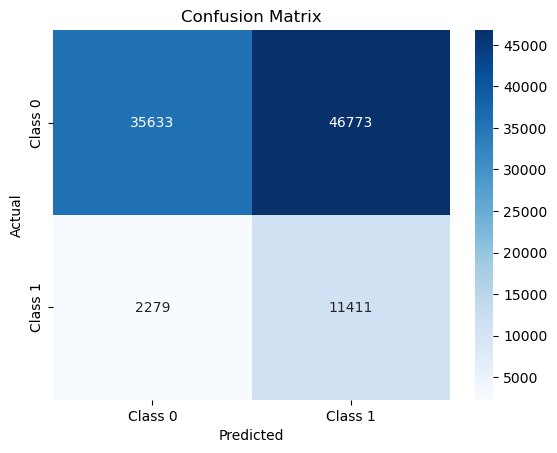

In [47]:
# confusion matrix 

draw_confusion_matrix(y_test, y_pred)

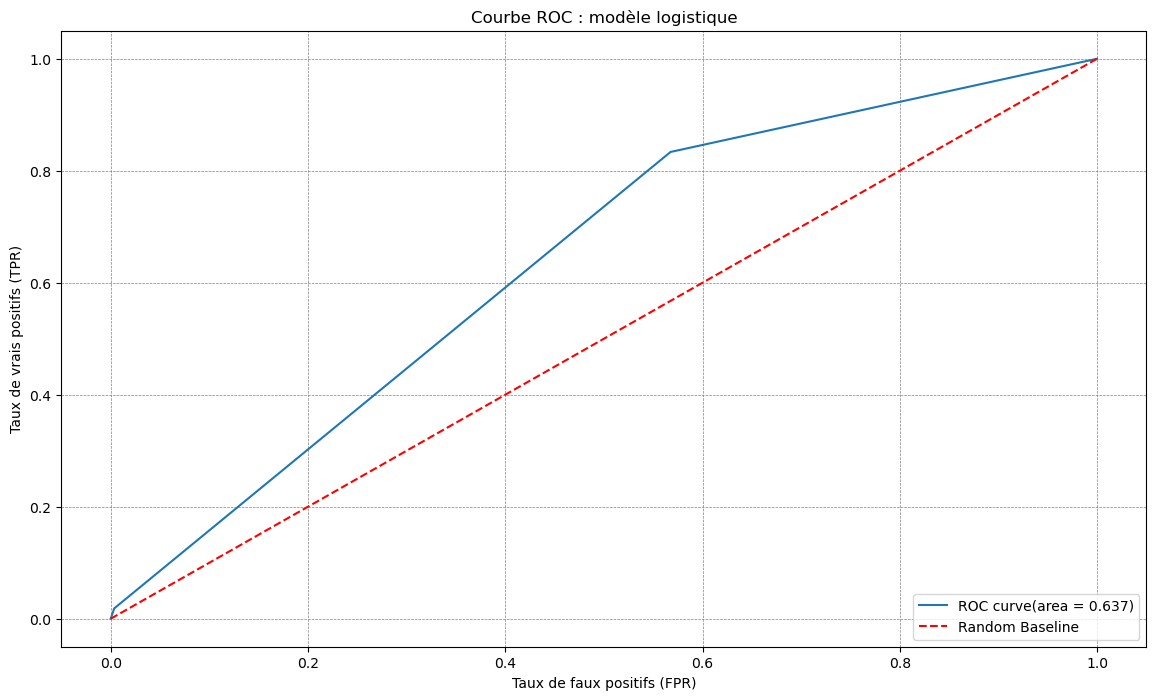

In [48]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = random_forest_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : random forest')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes 

In [10]:

clf = GaussianNB()
clf.fit(X_train, y_train)

/opt/mamba/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [11]:
# print results for the best model

y_pred = clf.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.8780906593406593
F1 Score: 0.3673381217259815
Recall Score: 0.24842951059167276


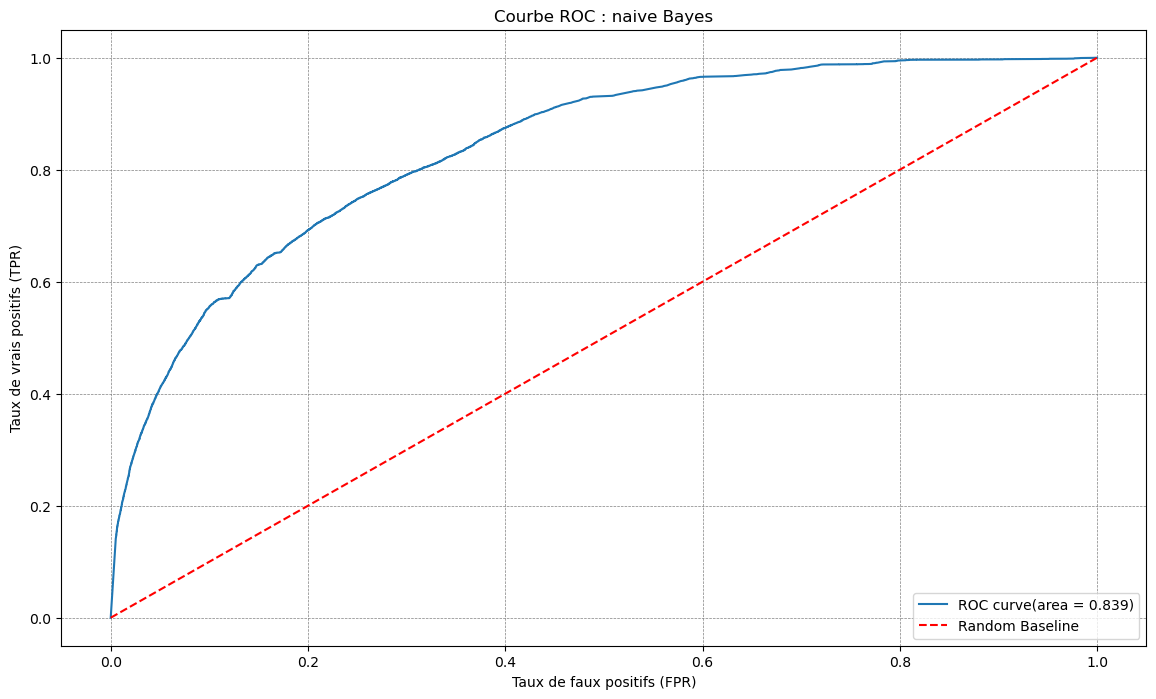

In [12]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : naive Bayes')
plt.legend(loc="lower right")
plt.show()

/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


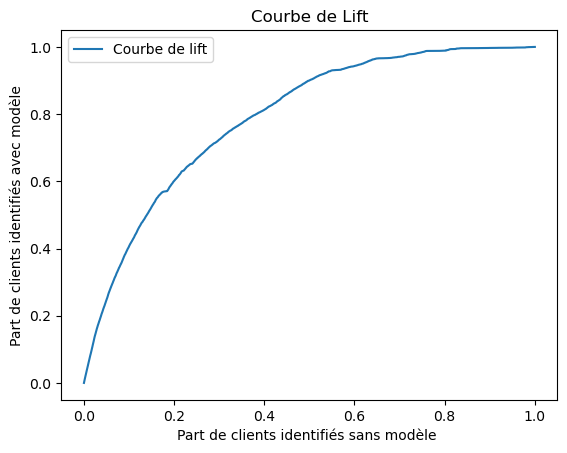

In [13]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label='Courbe de lift')
plt.xlabel('Part de clients identifiés sans modèle ')
plt.ylabel('Part de clients identifiés avec modèle')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

## From model to segmentation

(array([9.0362e+04, 2.7200e+02, 1.6700e+02, 1.0000e+02, 8.6000e+01,
        5.7000e+01, 6.6000e+01, 6.3000e+01, 4.5000e+01, 5.1000e+01,
        5.4000e+01, 3.6000e+01, 5.3000e+01, 5.3000e+01, 5.3000e+01,
        5.1000e+01, 7.7000e+01, 1.1800e+02, 1.2700e+02, 4.2050e+03]),
 array([8.76852176e-09, 5.00000083e-02, 1.00000008e-01, 1.50000007e-01,
        2.00000007e-01, 2.50000007e-01, 3.00000006e-01, 3.50000006e-01,
        4.00000005e-01, 4.50000005e-01, 5.00000004e-01, 5.50000004e-01,
        6.00000004e-01, 6.50000003e-01, 7.00000003e-01, 7.50000002e-01,
        8.00000002e-01, 8.50000001e-01, 9.00000001e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

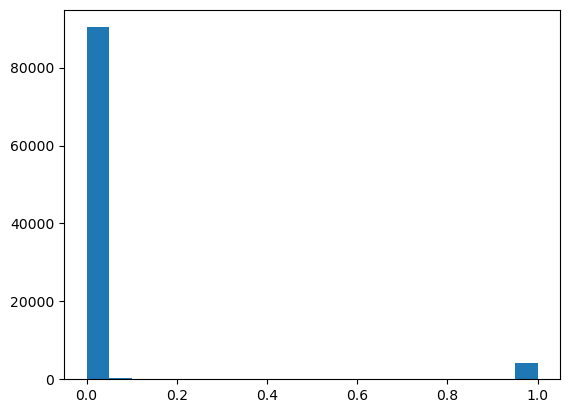

In [36]:
plt.hist(y_pred_prob, bins=20)

In [39]:
np.sort(y_pred_prob)

array([8.76852176e-09, 8.76852176e-09, 8.76852176e-09, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [43]:
(y_pred_prob>0.8).sum()

4527

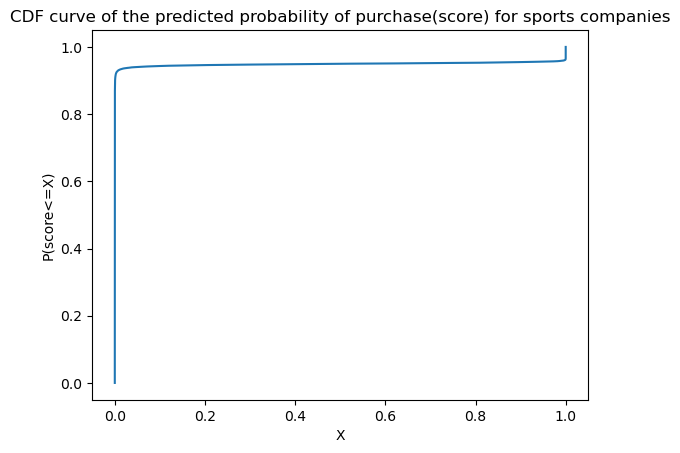

In [54]:
# number of observations
N = len(y_pred_prob)

# sort the data in ascending order 
y_pred_prob_sorted = np.sort(y_pred_prob) 

# get the cdf values of y 
steps = np.arange(N) / N
  
# plotting 
plt.xlabel('X') 
plt.ylabel('P(score<=X)') 
  
plt.title('CDF curve of the predicted probability of purchasec(score) for sports companies') 
  
plt.plot(y_pred_prob_sorted, steps) 
plt.show()

In [60]:
# on regarde de plus près les quantiles (on identifie 2 clusters, où est le cut-off ?)

np.linspace(0,1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [59]:
y_pred_prob_sorted[y_pred_prob < 0.1].shape

(90634,)

In [65]:
for step in np.linspace(0,1, 21) :
    score_reached = y_pred_prob_sorted[int(step*N)-1]
    print(f"score du quantile {step} : {score_reached}")



score du quantile 0.0 : 1.0
score du quantile 0.05 : 1.1703610048497538e-08
score du quantile 0.1 : 1.1916538583855572e-08
score du quantile 0.15000000000000002 : 1.672960453020865e-08
score du quantile 0.2 : 2.261530896018714e-08
score du quantile 0.25 : 4.429426100901144e-08
score du quantile 0.30000000000000004 : 5.527720441770875e-08
score du quantile 0.35000000000000003 : 6.583003552085313e-08
score du quantile 0.4 : 1.0150014636815537e-07
score du quantile 0.45 : 1.045553983975125e-07
score du quantile 0.5 : 1.8254643649033717e-07
score du quantile 0.55 : 1.0036337913333724e-06
score du quantile 0.6000000000000001 : 3.6006418270834777e-06
score du quantile 0.65 : 8.750051427856617e-06
score du quantile 0.7000000000000001 : 1.7761176996762073e-05
score du quantile 0.75 : 3.658511676930477e-05
score du quantile 0.8 : 7.449089979671675e-05
score du quantile 0.8500000000000001 : 0.0001599334998042523
score du quantile 0.9 : 0.0006156933309033692
score du quantile 0.9500000000000001 :

In [67]:
# le saut survient entre le quantile 0.94 et 0.955
# on peut prendre le quantile 0.95 / score = 0.52 comme cut-off approximatif
for step in np.linspace(0.94,0.96, 21) :
    score_reached = y_pred_prob_sorted[int(step*N)-1]
    print(f"score du quantile {step} : {score_reached}")

score du quantile 0.94 : 0.046364832132301186
score du quantile 0.941 : 0.060426331367796585
score du quantile 0.942 : 0.07560789365683944
score du quantile 0.943 : 0.0961854989484283
score du quantile 0.944 : 0.12036366182214445
score du quantile 0.945 : 0.15326229828189683
score du quantile 0.946 : 0.20141929276940546
score du quantile 0.947 : 0.26129057078459816
score du quantile 0.948 : 0.34459110917836233
score du quantile 0.949 : 0.42441766527261676
score du quantile 0.95 : 0.5161846499348189
score du quantile 0.951 : 0.6281715747542238
score du quantile 0.952 : 0.7161294443763133
score du quantile 0.953 : 0.8098274658632696
score du quantile 0.954 : 0.8628210594682936
score du quantile 0.955 : 0.9031546758694196
score du quantile 0.956 : 0.9406325197642711
score du quantile 0.957 : 0.9717094630837765
score du quantile 0.958 : 0.9853416074407844
score du quantile 0.959 : 0.99263528504162
score du quantile 0.96 : 0.9965103675841931


In [90]:
# simple K-means pour déterminer le seuil qui sépare les 2 clusters apparents

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(y_pred_prob.reshape(-1,1))

KMeans(n_clusters=2, random_state=0)

In [91]:
y_clusters = kmeans.predict(y_pred_prob.reshape(-1,1))
y_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [93]:
y_clusters[y_clusters==1].size

4846

In [94]:
# 5% des individus sont dans le cluster 1
1 - y_clusters.mean()

0.9495712620712621

Intérêt du K-means : permet d'identifier un seuil de passage d'un cluster à l'autre quand le cluster est restreint, comme ici où on isole les clients avec la proba d'achat dans le quantile 0.95, et on les sépare des 95% restant

In [95]:
# seuil de split 

size_cluster_0 = 1 - y_clusters.mean()
seuil_cluster = y_pred_prob_sorted[int(1 - y_clusters.mean()*N)]

print(f"part d'individus dans le cluster 0 : {size_cluster_0}")
print(f"seuil de passage du cluster 0 au cluster 1 : {seuil_cluster}")

part d'individus dans le cluster 0 : 0.9495712620712621
seuil de passage du cluster 0 au cluster 1 : 0.4855790414879801
